# Time Series Analysis
A time series is a sequence of data points, each associated with a time. In our example, we will work with a time series of daily temperatures in the city of Melbourne, Australia over a period of a few years. Let $x$ be the vector of the time series, and $x_i$ denote the temperature in Melbourne on day $i$. Here is a picture of the time series:

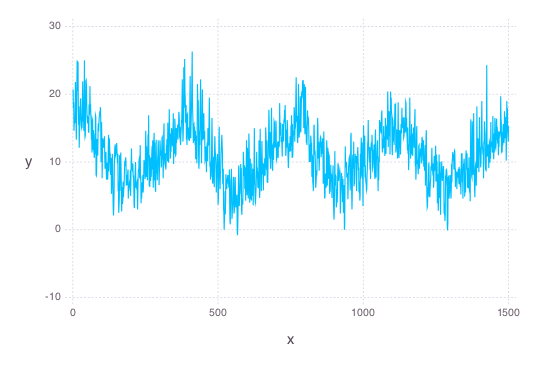

In [1]:
using Gadfly, Convex, SCS, Interact
set_default_solver(SCSSolver(verbose=0, max_iters=3000))

# grab data
temps = readdlm("melbourne_temps.txt", ',')
temps = temps[1:1500]
n = length(temps)
p = plot(
  x=1:n, y=temps[1:n], Geom.line,
  Theme(panel_fill=color("white"))
)

We can quickly compute the mean of the time series to be $11.2$. If we were to always guess the mean as the temperature of Melbourne on a given day, the RMS error of our guesswork would be $4.1$. We'll try to lower this RMS error by coming up with better ways to model the temperature than guessing the mean.

A simple way to model this time series would be to find a smooth curve that approximates the yearly ups and downs.
We can represent this model as a vector $s$ where $s_i$ denotes the temperature on the $i$-th day.
To force this trend to repeat yearly, we simply want

$$s_i = s_{i + 365}$$

for each applicable $i$.

We also want our model to have two more properties:

- The first is that the temperature on each day in our model should be relatively close to the actual temperature of that day.
- The second is that our model needs to be smooth, so the change in temperature from day to day should be relatively small. The following objective would capture both properties:

$$\sum_{i = 1}^n (s_i - x_i)^2 + \lambda \sum_{i = 2}^n(s_i - s_{i - 1})^2$$

where $\lambda$ is the smoothing parameter. The larger $\lambda$ is, the smoother our model will be.

The following code uses Convex to find and plot the model:

Slider{Int64}([Input{Int64}] 25,"lambda",25,0:1:50)

elapsed time: 29.262155957 seconds (406102136 bytes allocated, 2.55% gc time)


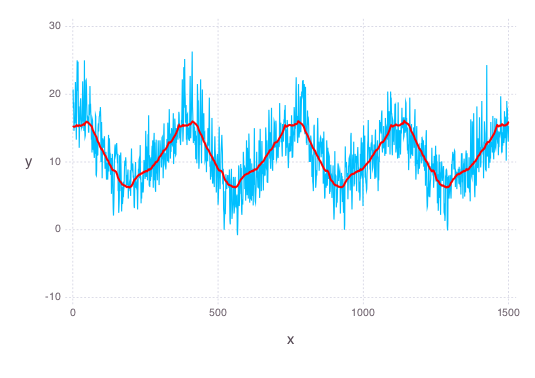

In [2]:
# predict the same temperature on the same day each year
yearly = Variable(n)
equality_constraint = (yearly[1:n-365] == yearly[366:n])

# temperatures on subsequent days should be similar
diff(x::AbstractExpr) = x[1:end] - [x[2:end], x[1]]
smooth_objective = sum_squares(diff(yearly))
error_objective = sum_squares(temps - yearly)
# can try different objectives to see if fit is robust to error distribution
#error_objective = norm(temps - yearly, Inf)
#error_objective = maximum(abs(temps - yearly))*n

@manipulate for lambda = 0:1:50
    problem = minimize(error_objective + lambda * smooth_objective, equality_constraint)
    @time solve!(problem)

    # Plot smooth fit
    p = plot(
    layer(x=1:n, y=yearly.value, Geom.line, Theme(default_color=color("red"), line_width=2px)),
    layer(x=1:n, y=temps, Geom.line),
    Scale.x_continuous(minvalue=0, maxvalue=n), Scale.y_continuous(minvalue=-5, maxvalue=30),
    Theme(panel_fill=color("white"))
    )
end

We can also plot the residual temperatures, $r$, defined as $r = x - s$.

elapsed time: 0.547804551 seconds (7995492 bytes allocated)


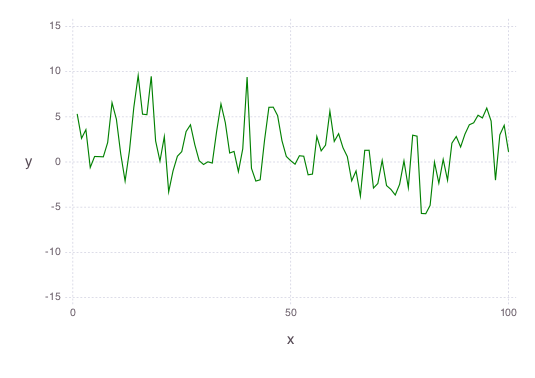

In [3]:
# Plot residuals for a few days
lambda = 20
problem = minimize(error_objective + lambda * smooth_objective, equality_constraint)
@time solve!(problem)

residuals = temps - evaluate(yearly)
# plot residuals
p = plot(
    x=1:100, y=residuals[1:100], Geom.line,
    Scale.y_continuous(minvalue=-15, maxvalue=15),
    Theme(default_color=color("green"), panel_fill=color("white"))
)

In [4]:
println("Our smooth model has a RMS error of $(round(sqrt(evaluate(error_objective)/n)[1],2)),
a significant improvement from just guessing the mean with RMS $(round(sqrt(sum((temps - mean(temps)).^2)/n),2)),
but we can do better.")

Our smooth model has a RMS error of 2.8,
a significant improvement from just guessing the mean with RMS 4.29,
but we can do better.


We now make the hypothesis that the residual temperature on a given day is some linear combination of the previous $5$ days. Such a model is called autoregressive. We are essentially trying to fit the residuals as a function of other parts of the data itself. We want to find a vector of coefficients $a$ such that

$$\mbox{r}(i) \approx \sum_{j = 1}^5 a_j \mbox{r}(i - j)$$

This can be done by simply minimizing the following sum of squares objective

$$\sum_{i = 6}^n \left(\mbox{r}(i) - \sum_{j = 1}^5 a_j \mbox{r}(i - j)\right)^2$$

The following Convex code solves this problem and plots our autoregressive model against the actual residual temperatures:

Slider{Int64}([Input{Int64}] 5,"ar_len",5,1:1:10)

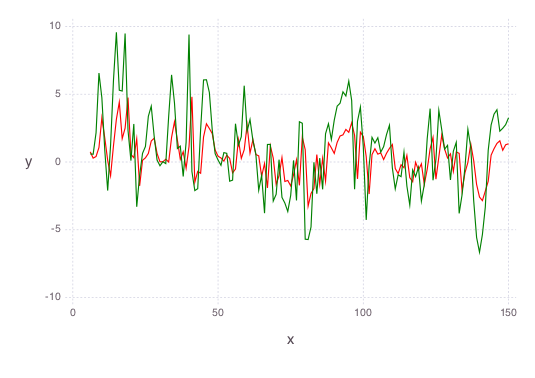

In [5]:
# Generate the residuals matrix
@manipulate for ar_len = 1:1:10
residuals_mat = residuals[ar_len : n - 1]
for i = 1:ar_len - 1
  residuals_mat = [residuals_mat residuals[ar_len - i : n - i - 1]]
end

# Solve autoregressive problem
ar_coef = Variable(ar_len)
problem = minimize(sum_squares(residuals_mat * ar_coef - residuals[ar_len + 1 : end]))
solve!(problem, SCSSolver(max_iters=5000, verbose=0))

# plot autoregressive fit of daily fluctuations for a few days
ar_range = 1:145
day_range = ar_range + ar_len
p = plot(
  layer(x=day_range, y=residuals[day_range], Geom.line, Theme(default_color=color("green"))),
  layer(x=day_range, y=residuals_mat[ar_range, :] * evaluate(ar_coef), Geom.line, 
  Theme(default_color=color("red"))),
  Theme(panel_fill=color("white"))
)
end

Now, we can add our autoregressive model for the residual temperatures to our smooth model to get an better fitting model for the daily temperatures in the city of Melbourne:

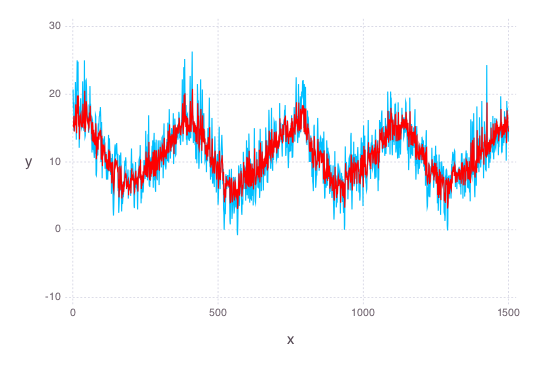

In [6]:
ar_len = 2
residuals_mat = residuals[ar_len : n - 1]
for i = 1:ar_len - 1
  residuals_mat = [residuals_mat residuals[ar_len - i : n - i - 1]]
end

# Solve autoregressive problem
ar_coef = Variable(ar_len)
problem = minimize(sum_squares(residuals_mat * ar_coef - residuals[ar_len + 1 : end]))
solve!(problem, SCSSolver(max_iters=5000, verbose=0))

# plot autoregressive fit of daily fluctuations for a few days
ar_range = 1:145
day_range = ar_range + ar_len
p = plot(
  layer(x=day_range, y=residuals[day_range], Geom.line, Theme(default_color=color("green"))),
  layer(x=day_range, y=residuals_mat[ar_range, :] * evaluate(ar_coef), Geom.line, 
  Theme(default_color=color("red"))),
  Theme(panel_fill=color("white"))
)

total_estimate = evaluate(yearly)
total_estimate[ar_len + 1 : end] += residuals_mat * evaluate(ar_coef)

# plot final fit of data
p = plot(
  layer(x=1:1500, y=total_estimate[1:1500], Geom.line, Theme(default_color=color("red"))),
  layer(x=1:1500, y=temps[1:1500], Geom.line),
  Theme(panel_fill=color("white"))
)

In [7]:
println("The RMS error of this final model is $(round(sqrt(evaluate(error_objective)/n)[1],2)).")

The RMS error of this final model is 2.45.
